# Simulator Testing 0

The following code defines an ellipse corresponding to the path around the globe an orbit takes

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplp
import scipy
from datetime import datetime
from nrlmsise00 import msise_model

radius_polar = 6356752
radius_equatorial = 6378137
earth_eccentricity_squared = 6.694379e-3
M_e = 5.972e24
G = 6.673e-11
rho_0 = 1.225
H = 8400.0 
A = np.pi * (3.3 / 2)**2  # m^2, satellite windward area

In [15]:
def satellite_forces_simple(altitude, velocity, C_d):
    # Extract coordinates

    # Atmospheric density calculation
    rho = rho_0 * np.exp(-altitude / H)

    velocity = np.array(velocity)
    # Drag force calculation
    Fd = 0.5 * rho * velocity**2 * C_d * A

    return Fd

In [16]:
def satellite_forces_complex(time, position, lat, lon, velocity, altitude, C_d = 2.2):

    # Convert position vector to Earth center coordinates
    
    # Obtain atmospheric density using the NRLMSISE-00 model
    output = msise_model(time, altitude, lat, lon, 150, 150, 4, lst=16)
    #first 150 is the 81-day sliding average of solar aactivity, representing the solar radiation index
    #seconde 150 is the previous day sliding average of solar activity, representing the solar radiation index
    # 4 is the index of geomagnetic activity reflects the degree of disturbance of the Earth's magnetic field
    # lst=16 is the local solar time
    rho = output[0][5]  # Total mass density in kg/m^3

    # Calculate drag force components
    velocity = np.array(velocity)

    Fd = 0.5 * rho * velocity**2 * C_d * A

    return Fd  # Return both magnitude and direction tuple

In [4]:
def Cart2Spher(positions):
    sphercoords = np.zeros(positions.shape)
    xy2 = positions[:,0]**2 + positions[:,1]**2
    sphercoords[:,0] = np.sqrt(xy2 + positions[:,2]**2)
    sphercoords[:,1] = np.arctan2(np.sqrt(xy2), positions[:,2])
    sphercoords[:,2] = np.arctan2(positions[:,1],positions[:,0])
    return sphercoords

def Spher2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    cartcoords[:,0] = positions[:,0] * np.sin(positions[:,1]) * np.cos(positions[:,2])
    cartcoords[:,1] = positions[:,0] * np.sin(positions[:,1]) * np.sin(positions[:,2])
    cartcoords[:,2] = positions[:,0] * np.cos(positions[:,1])
    return cartcoords

def Geodetic2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    N_phi = radius_equatorial / (np.sqrt(1 - earth_eccentricity_squared*np.sin(positions[:,0])**2))
    cartcoords[:,0] = (N_phi + positions[:,2]) * np.cos(positions[:,0]) * np.cos(positions[:,1])
    cartcoords[:,1] = (N_phi + positions[:,2]) * np.cos(positions[:,0]) * np.sin(positions[:,1])
    cartcoords[:,2] = ((1-earth_eccentricity_squared)*N_phi + positions[:,2]) * np.sin(positions[:,0])
    return cartcoords

def Cart2Geodetic(positions):
    geodeticcoords = np.zeros(positions.shape)
    geodeticcoords[:,1] = np.arctan2(positions[:,1], positions[:,0])
    k_0 = 1/(1 - earth_eccentricity_squared)
    k = k_0
    p = np.sqrt(positions[:,0]**2 + positions[:,1]**2)
    for i in range(3):
        ci = ((p**2 + (1-earth_eccentricity_squared) * positions[:,2]**2 * k**2)**(3/2))/ (radius_equatorial * earth_eccentricity_squared)
        k = 1 + (p**2 + (1-earth_eccentricity_squared)*positions[:,2]**2*k**3)/(ci - p**2)
    
    geodeticcoords[:,2] = 1/earth_eccentricity_squared * (1/k - 1/k_0) * np.sqrt(p**2 + positions[:,2]**2 * k **2)
    geodeticcoords[:,0] = np.arctan2((k * positions[:,2]), p)
    return geodeticcoords

def Polar2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    cartcoords[:,0] = positions[:,0] * np.cos(positions[:,1])
    cartcoords[:,1] = positions[:,0] * np.sin(positions[:,1])
    return cartcoords

def Cart2Polar(positions):
    polarcoords = np.zeros(positions.shape)
    polarcoords[:,0] = np.sqrt(positions[:,0]**2 + positions[:,1]**2)
    polarcoords[:,1] = np.arctan2(positions[:,1],positions[:,0])
    return polarcoords

In [5]:
test_points = np.array([[1,1],[1,2]])
Cart2Polar(Polar2Cart(test_points))

array([[1., 1.],
       [1., 2.]])

In [6]:
class Ellipse:
    def __init__(self, centre, height, width, angle=0):
        self.x, self.y = centre
        self.w = width
        self.h = height
        self.theta = angle
    
    def r(self):
        """
        Defines the rotation matrix used to transform coordinates to 0-centred model
        """
        a = np.cos(self.theta)
        b = np.sin(self.theta)
        return np.array([[a,-b],[b,a]])
    
    def point_at_angle(self, angle):
        """
        Given an interior angle from an ellipse's centre, finds a point on the ellipse.
        """
        #Compute location of original point
        x_or = 0.5 * self.w * np.cos(angle)
        y_or = 0.5 * self.h * np.sin(angle)

        #rotate the point to the centred version of the ellipse
        rot_point = np.dot(self.r(), [x_or, y_or]) + [self.x, self.y]
        return rot_point
    
    def multi_points(self, locations):
        """
        Given an array of interior angles, this returns an array of positions on the ellipse.
        """
        points_array = []
        for loc in locations:
            points_array.append(self.point_at_angle(loc))
        return np.array(points_array)
    
    def closest_point(self, x, tol=1e-6, max_iter = 100):
        """
        Given a point outside the ellipse, and finds the point on the ellipse closest to this.
        It also returns the (smallest) distance between the point and the ellipse.
        """
        #First need to project the point to the space where ellipse centred at origin
        #Also, need to initialize the constants
        x = np.asarray(x)
        x2 = np.dot(self.r().T, x - [self.x, self.y])
        d0 = np.arctan2(x2[1], x2[0])
        a = 0.5 * self.w
        b = 0.5 * self.h
        #Check if points are in the interior of the ellipse
        if (x2[0] / a)**2 + (x2[1] / b)**2 <1:
            print("Initial point in interior!")
            return np.array(0), None
        
        iterations = 0
        ds = [d0]
        xs = []
        errors = [tol]

        while errors[-1] >= tol and iterations < max_iter:
            x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
            xs.append(x1)
            dx1dt = np.array([-a *np.sin(ds[-1]), b * np.cos(ds[-1])])
            dx1dt2 = np.array([-a * np.cos(ds[-1]), -b * np.sin(ds[-1])])
            dD2dt = 2*np.dot(dx1dt,(x1 - x2))
            dD2dt2 = 2*np.dot(dx1dt2,(x1-x2)) + 2*np.dot(dx1dt,dx1dt)
            ds.append(ds[-1] - dD2dt / dD2dt2)
            errors.append(np.abs(dD2dt/dD2dt2))
            iterations +=1
        
        x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
        dist = np.linalg.norm(x1 - x2)
        return dist, xs[-1]




To Be Fixed: currently only keeps track of position for (0,0) centred ellipse coords! Needs to be fixed!

In [7]:
#Here are some global variables
polar_ellipse = Ellipse((0,0), 2*radius_polar, 2*radius_equatorial)
simple_polar_ellipse = Ellipse((0,0), 2*(radius_polar/1000), 2*(radius_equatorial/1000))

In [91]:
class D2_Satellite:
    def __init__(self, mass, dragcoeff, init_position, init_veloc, tangential_velocity = False):
        """
        Begin by defining relevant attributes of a satellite, initial poisition,
        and set up arrays to track movement of satellite.
        """
        self.mass = mass
        self.altitude = None
        self.althist = None
        self.dragcoeff = dragcoeff
        self.position = init_position
        if tangential_velocity == True:
            angle = np.arctan2(self.position[1],self.position[0])
            self.velocity = [np.cos(angle) * init_veloc, np.sin(angle) * init_veloc]
        else:
            self.velocity = init_veloc
        self.poshist = [init_position]
        self.velochist = [init_veloc]

    def calcAltitude(self, ell: Ellipse):
        """
        Given a satellite and an ellipse, this performs the same calculation as the ellipse
        But more from a "Sattelite" POV
        """
        altitude, ground_pos = ell.closest_point(self.position)
        return altitude, ground_pos
    
    def calcGravAcc(self, ell: Ellipse):
        """
        Given a satellite's position, and accounting for non-zero-centred ellipses, computes
        The gravitational accelleration experienced by the satellite at that position
        """
        grav_acc = -G*M_e / np.linalg.norm(np.array(self.position) - np.array([ell.x, ell.y]))**2
        theta = np.arctan2(self.position[1], self.position[0])
        return np.array([grav_acc * np.cos(theta),grav_acc * np.sin(theta)])

    def calcDrag(self, altitude):
        """
        Ideally takes a reference from the physical parameters team to estimate drag
        """
        drag = satellite_forces_simple(altitude, self.velocity, self.dragcoeff)
        return drag
        
        

    def FEtimeStep(self, ell: Ellipse, dt):
        """
        Takes a timestep using Forward Euler
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        if self.altitude <=0:
            return 
        drag_a = self.calcDrag(self.altitude) / self.mass
        grav_a = self.calcGravAcc(ell)
        tot_a = drag_a + grav_a
        new_veloc = self.velocity + dt * tot_a
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        new_position = self.position + dt * self.velocity
        self.position = new_position
        self.poshist.append(new_position)
    
    def Gen_TimeStep(self, ell: Ellipse, dt, solver='RK45'):
        self.altitude, groundpos = self.calcAltitude(ell)
        if self.altitude <=0:
            return
        drag_a = self.calcDrag(self.altitude) / self.mass
        grav_a = self.calcGravAcc(ell)
        tot_a = -drag_a + grav_a
        veloc_func = lambda t, v: tot_a
        veloc_sol = scipy.integrate.solve_ivp(veloc_func, [0,dt], self.velocity, method=solver, t_eval = [dt])
        new_veloc = [veloc_sol.y[0][0].tolist(),veloc_sol.y[1][0].tolist()]
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        pos_func = lambda t,x: self.velocity
        pos_sol = scipy.integrate.solve_ivp(pos_func, [0,dt], self.position, method=solver, t_eval=[dt])
        new_pos = [pos_sol.y[0][0].tolist(),pos_sol.y[1][0].tolist()]
        self.position = new_pos
        self.poshist.append(new_pos)
    
    def forecast(self, ell: Ellipse, dt=0.001, maxIter = 100000, height_tol = 10000, simple_solver = False, solver = 'RK45'):
        """
        Runs the forward euler timestep until our altitude reaches 0. Can adjust dt as seen fit
        To be fixed: breaks when altitude drops below 10km or so.
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        iter = 0

        if self.althist is None:
            self.althist = [self.altitude]
        
        if simple_solver == True:
            while self.altitude > height_tol and iter < maxIter:
                self.FEtimeStep(ell, dt)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter +=1
            return self.poshist, self.velochist, self.althist
        
        else:
            while self.altitude > height_tol and iter < maxIter:
                self.Gen_TimeStep(ell, dt, solver=solver)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter += 1
            return self.poshist, self.velochist, self.althist


In [92]:
sat1 = D2_Satellite(3000, 2.2, [7378000, 0], [-7000,0])
ell1 = Ellipse((0,0), radius_equatorial*2, radius_equatorial*2)

In [93]:
#print(ell1.closest_point([7378, 0]))
sat1 = D2_Satellite(3000, 2.2, [0, radius_equatorial+408000], [7650,100])
ell1 = Ellipse((0,0), radius_equatorial*2, radius_equatorial*2)
dt = 0.1
poshist, velochist, althist = sat1.forecast(ell1, dt = dt, height_tol = 0)

In [94]:
def D2_orbitplotter(poshist, althist, ell1,dt):
    fig, axs = plt.subplots(1,2)
    axs.flatten()[0].plot(althist[0::int(1/dt)], label = "Altitude")
    axs.flatten()[0].set_xlabel("Time (s)")
    axs.flatten()[0].set_ylabel("Altitude (m)")
    axs.flatten()[0].set_title("Altitude of Satellite")
    axs.flatten()[0].legend()
    ellipse = mplp.Ellipse((ell1.x,ell1.y),ell1.w, ell1.h, angle = ell1.theta, fill=False, color = 'r')
    axs.flatten()[1].add_patch(ellipse)
    axs.flatten()[1].plot(poshist[:,0], poshist[:,1], label = "Position")
    axs.flatten()[1].set_aspect('equal')
    axs.flatten()[1].set_title("Path of Satellite (2D Projection)")
    #axs.flatten()[1].legend(loc='upper left')

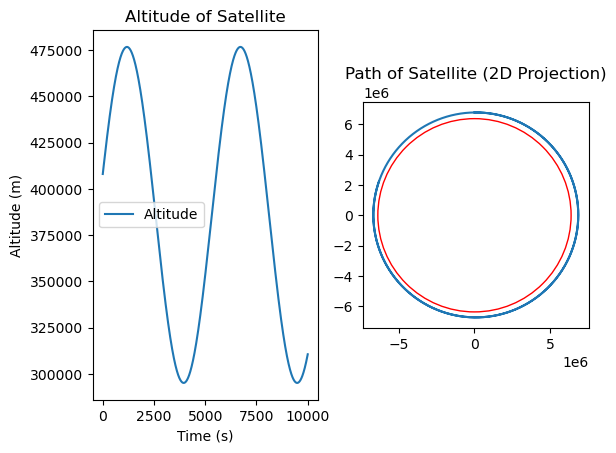

In [95]:
poshist = np.array(poshist)
D2_orbitplotter(poshist, althist, ell1, dt)

In [23]:
radar_angs = np.arange(0,2*np.pi,np.pi/2)
positions = ell1.multi_points(radar_angs)
noisy_position = np.zeros(poshist.shape)
for position in poshist:
    noisy_position = position + np.random.normal(0,0.03*np.abs(position))
np.savetxt("data_test.csv", noisy_position, delimiter=",")

In [158]:
class D3_Satellite:
    def __init__(self, mass, dragcoeff, init_position, init_veloc, time = datetime(2009, 6, 21, 8, 3, 20)):
        """
        Begin by defining relevant attributes of a satellite, initial poisition,
        and set up arrays to track movement of satellite.
        """
        self.mass = mass
        self.time = time
        self.altitude = None
        self.althist = None
        self.dragcoeff = dragcoeff
        self.position = init_position
        self.velocity = init_veloc
        self.poshist = [init_position]
        self.velochist = [init_veloc]
    
    def calcAltitude(self, kilometers = True):
        """
        Given a satellite and an ellipse, this performs the same calculation as the ellipse
        But more from a "Sattelite" POV
        """

        spher_coords = Cart2Spher(np.array([self.position]))[0][:2]
        transformed_coords = Polar2Cart(np.array([[spher_coords[0],-spher_coords[1]+np.pi/2]]))[0]
        
        if kilometers == True:
            altitude, ground_pos = simple_polar_ellipse.closest_point(transformed_coords)
        else:
            altitude, groundpos = polar_ellipse.closest_point(transformed_coords)
        return altitude, ground_pos
    
    def calcGravAcc(self):
        """
        Given a satellite's position, and accounting for non-zero-centred ellipses, computes
        The gravitational accelleration experienced by the satellite at that position
        """
        grav_acc = -G*M_e / np.linalg.norm(np.array(self.position))**2
        normpos = self.position / np.linalg.norm(self.position)
        grav_acc_direct = grav_acc * np.array(normpos)
        return grav_acc_direct
    
    def calcDragForce(self):
        [_, lat, lon] = Cart2Spher(np.array([self.position]))[0]
        if self.altitude is None:
            self.altitude, _ = self.calcAltitude()
            self.althist = [self.altitude]
        drag_force = satellite_forces(self.time, self.position, lat, lon, self.velocity, self.altitude, C_d = self.dragcoeff)
        return drag_force
    
    def Gen_TimeStep(self, dt, solver='RK45'):
        self.altitude, groundpos = self.calcAltitude()
        if self.altitude <=0:
            return
        drag_a = self.calcDragForce() / self.mass
        grav_a = self.calcGravAcc()
        tot_a = drag_a + grav_a
        veloc_func = lambda t, v: tot_a
        veloc_sol = scipy.integrate.solve_ivp(veloc_func, [0,dt], self.velocity, method=solver, t_eval = [dt])
        new_veloc = [veloc_sol.y[0][0].tolist(),veloc_sol.y[1][0].tolist(),veloc_sol.y[2][0].tolist()]
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        pos_func = lambda t,x: self.velocity
        pos_sol = scipy.integrate.solve_ivp(pos_func, [0,dt], self.position, method=solver, t_eval=[dt])
        new_pos = [pos_sol.y[0][0].tolist(),pos_sol.y[1][0].tolist(),pos_sol.y[2][0].tolist()]
        self.position = new_pos
        self.poshist.append(new_pos)
    
    def forecast(self, dt=0.001, maxIter = 1000000, height_tol = 0, simple_solver = False, solver = 'RK45'):
        """
        Runs the forward euler timestep until our altitude reaches 0. Can adjust dt as seen fit
        To be fixed: breaks when altitude drops below 10km or so.
        """
        self.altitude, groundpos = self.calcAltitude()
        iter = 0

        if self.althist is None:
            self.althist = [self.altitude]
        
        if simple_solver == False:
            while self.altitude > height_tol and iter < maxIter:
                self.Gen_TimeStep(dt, solver=solver)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter += 1
            return self.poshist, self.velochist, self.althist
    


In [1]:
init_position = [7378.0,0,0]
sat = D3_Satellite(3000, 2.2, init_position, [7,0,0])
poshist, _, althist = sat.forecast(dt = 0.000001);

NameError: name 'D3_Satellite' is not defined

In [236]:
class D2_radar_array:
    def __init__(self, cart_pos):
        self.positions = np.array(cart_pos)
    
    def general_identify(self, id_pos):
        id_pos = np.array(id_pos)
        found_pos = []
        for i, id_pos_i in enumerate(id_pos):
            found_pos_i = np.zeros(np.array(self.positions).shape)
            for j, pos in enumerate(self.positions):
                found_pos_i[j,:] = id_pos_i - pos
            found_pos.append(found_pos_i)
        return found_pos
    
    def satellite_identify(self, sat: D2_Satellite, noise_level = 0.05):
        poshist = sat.poshist
        noisy_pos = np.zeros(np.array(poshist).shape)
        for i, pos in enumerate(poshist):
            print(pos)
            for j in range(len(pos)):
                noisy_pos[i][j] = pos[j] + np.random.normal(0,noise_level*pos[j])
        return self.general_identify(poshist)


In [237]:
class D3_radar_array:
    def __init__(self, cart_pos):
        self.positions = cart_pos
    
    def general_identify(self, id_pos):
        id_pos = np.array(id_pos)
        found_pos = []
        for i, id_pos_i in enumerate(id_pos):
            found_pos_i = np.zeros(np.array(self.positions).shape)
            for j, pos in enumerate(self.positions):
                found_pos_i[j,:] = id_pos_i - pos
            found_pos.append(found_pos_i)
        return found_pos
    
    def satellite_identify(self, sat: D2_Satellite, noise_level = 0.05):
        poshist = sat.poshist
        noisy_pos = np.zeros(np.array(poshist).shape)
        for i, pos in enumerate(poshist):
            for j in range(len(pos)):
                noisy_pos[i][j] = pos[j] + np.random.normal(0,noise_level*pos[j])
        return self.general_identify(poshist)

In [238]:
rad_test = D3_radar_array([[0,1,2],[1,1,2],[2,3,3]])
rad_test.satellite_identify(sat)

[7378.0, 0, 0]
[7377.999999679115, 6.469770748202594e-31, 6.469770748202594e-31]
[7377.999992037344, 1.2953136932514889e-30, 1.2953136932514889e-30]
[7377.999977074687, 2.714697405573499e-30, 2.714697405573499e-30]
[7377.999954791145, 7.09012121613393e-30, 7.09012121613393e-30]
[7377.999925186717, 1.8021884428365366e-29, 1.8021884428365366e-29]
[7377.999888261403, 4.05255939622414e-29, 4.05255939622414e-29]
[7377.999844015203, 8.103216614417241e-29, 8.103216614417241e-29]
[7377.999792448117, 1.4738782896934196e-28, 1.4738782896934196e-28]
[7377.999733560145, 2.4885412483648558e-28, 2.4885412483648558e-28]
[7377.999667351287, 3.9610791375511343e-28, 3.9610791375511343e-28]
[7377.9995938215425, 6.012413770251766e-28, 6.012413770251766e-28]
[7377.999512970911, 8.777620213891844e-28, 8.777620213891844e-28]
[7377.999424799394, 1.2405926836567688e-27, 1.2405926836567688e-27]
[7377.999329306989, 1.7060715358017047e-27, 1.7060715358017047e-27]
[7377.999226493698, 2.291952090531381e-27, 2.29195

[array([[ 7.378e+03, -1.000e+00, -2.000e+00],
        [ 7.377e+03, -1.000e+00, -2.000e+00],
        [ 7.376e+03, -3.000e+00, -3.000e+00]]),
 array([[ 7.378e+03, -1.000e+00, -2.000e+00],
        [ 7.377e+03, -1.000e+00, -2.000e+00],
        [ 7.376e+03, -3.000e+00, -3.000e+00]]),
 array([[ 7.37799999e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37699999e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37599999e+03, -3.00000000e+00, -3.00000000e+00]]),
 array([[ 7.37799998e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37699998e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37599998e+03, -3.00000000e+00, -3.00000000e+00]]),
 array([[ 7.37799995e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37699995e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37599995e+03, -3.00000000e+00, -3.00000000e+00]]),
 array([[ 7.37799993e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37699993e+03, -1.00000000e+00, -2.00000000e+00],
        [ 7.37599993e+03, -3.00000000e+00, 